### Comparing Our Multi-Wavelength Data

1. Strong-Lensing Mass vs X-ray Mass
2. ALMA vs GMOS Kinematic Maps


In [1]:
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [56]:
#system
from __future__ import division
import sys

#numpy
import numpy as np

import h5py
from types import SimpleNamespace

#matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set1_4 as brewermap
%matplotlib inline


#astropy
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import LambdaCDM
from astropy.coordinates import Angle
from astropy.io import ascii
from astropy.io import fits

#pandas
import pandas as pd

#scipy
import scipy

#seaborn
import seaborn as sns 

import importlib


In [3]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [4]:
#uncomment if need to reload module
importlib.reload(pf)

<module 'plotting_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/plotting_functions.py'>

In [5]:
#About my galaxy cluster
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!

cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

angular_diameter_distance = cosmo.angular_diameter_distance(z=zh) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=zh).to(u.kpc / u.arcsec)

### Strong-Lensing Mass vs X-ray Mass

In [7]:
#Load X-ray mass
specfit_savepath = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/'

cp_radius = np.load(specfit_savepath + 'radius.npy') * u.kpc
cp_total_mass = np.load(specfit_savepath + 'total_mass.npy') * u.Msun

#load strong-lensing mass

file_s14_mass_profile = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/lensing_mass_60.npy'
file_s14_rad_profile = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/lensing_radius_60.npy'

s14_mass_profile = np.load(file_s14_mass_profile) * u.solMass
s14_rad_profile = np.load(file_s14_rad_profile) * u.kpc

The X-ray mass is calculated within a sphere and the strong lesing mass within a cylinder. To compare them, need to convert the X-ray mass into a cylindrical mass

In [26]:
height = 20 * u.Mpc
xray_cyl_density = (cp_total_mass)/(np.pi * cp_radius**2 * height)#sl_mass_density / height
xray_cyl_mass = 2 * np.pi * np.trapz(y=xray_cyl_density * cp_radius, x=cp_radius)  * height


In [38]:
r_indices = [0, 1]

lensing_sphere_density = s14_mass_profile / (4/3 * np.pi * s14_rad_profile**3)
lensing_sphere_mass = 4/3 * np.pi * np.trapz(y=lensing_sphere_density[r_indices] * 
                                             s14_rad_profile[r_indices]**2, x=s14_rad_profile[r_indices])

In [47]:
lensing_sphere_mass_profile = []

for index in range(len(s14_rad_profile)):
    density = s14_mass_profile[index] / (4/3 * np.pi * s14_rad_profile[index]**3)
    mass = 4/3 * np.pi * np.trapz(y=density * s14_rad_profile[:index+1]**2, x=s14_rad_profile[:index+1])
    lensing_sphere_mass_profile.append(mass.value)

lensing_sphere_mass_profile = np.array(lensing_sphere_mass_profile) * u.solMass

In [53]:
np.save(specfit_savepath + 'spherical_lensing_mass_60', lensing_sphere_mass_profile.value)

### ALMA vs GMOS

CO vs Halpha velocity Difference and Dispersion Ratio Maps

In [58]:
#load gmos cube
gmos_data_directory = path_to_beads + 'Analysis/gmosBeads/'
fov = gmos_data_directory + 'reduced/SDSSJ1531+3414.acube.fits'
hdu, hdr, w = pf.open_fits(fov, naxis=2)

# Loading ppxf output for 1-Gaussian fit
save_path = ''.join((path_to_beads,'Analysis/gmosBeads/ppxf/fit_results/result_table/'))
filename = save_path + '2_ppxffit.hdf5'
f = h5py.File(filename, 'r')

In [55]:
Ha_flux, Ha_mask = sf.ppxf_masked_flux_maps(f, 'Ha', snr=3)
ha_vel_map, ha_fwhm_map = sf.ppxf_masked_vel_maps(f, Ha_mask)

In [59]:
#load alma
alma_path = ''.join((path_to_beads, 'Analysis/almaBeads/'))
vco32_file = ''.join((alma_path, 'reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'))
moment1_file = ''.join((vco32_file[:-5], '_M1.fits'))
moment2_file = ''.join((vco32_file[:-5] + '_M2.fits'))

moment1_hdu, moment1_hdr, m1wcs = pf.open_fits(moment1_file)
moment2_hdu, moment2_hdr, m2wcs = pf.open_fits(moment2_file)


alma_halpha_flux_map.fits


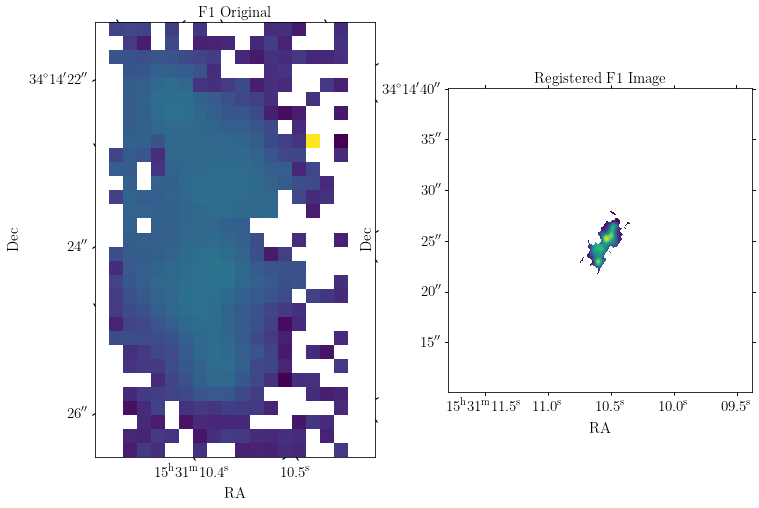

Successfully reprojected /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M1.fits to /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/gmosBeads/products/Halpha_flux_map.fits
saving new header to products folder
alma_halpha_vel_map.fits


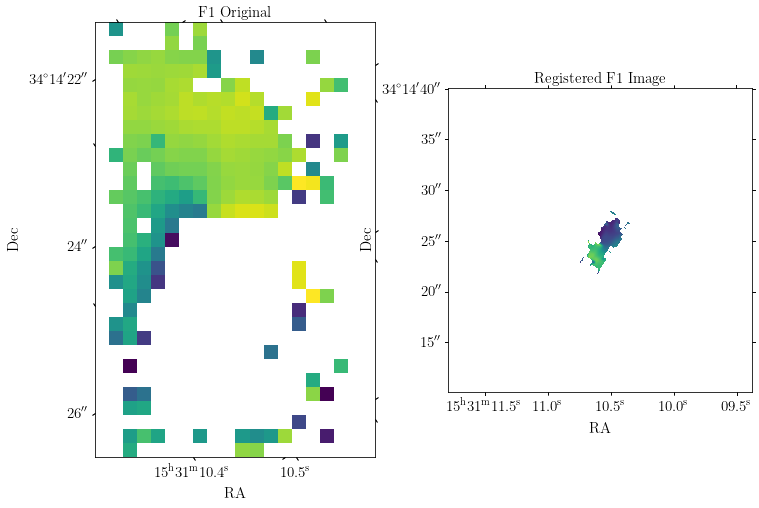

Successfully reprojected /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M1.fits to /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/gmosBeads/products/Halpha_vel_map.fits
saving new header to products folder
alma_halpha_fwhm_map.fits


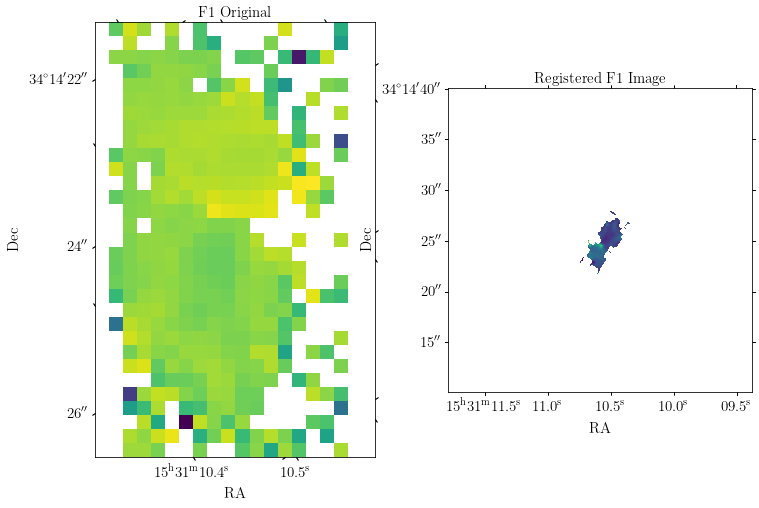

Successfully reprojected /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M1.fits to /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/gmosBeads/products/Halpha_fwhm_map.fits
saving new header to products folder


In [ ]:
#reproject gmos to ALMA
ha_hdu = fits.PrimaryHDU(data=Ha_flux, header=hdr)
ha_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/Halpha_flux_map.fits"))
ha_hdu.writeto(ha_file, overwrite=True)

hav_hdu = fits.PrimaryHDU(data=ha_vel_map, header=hdr)
hav_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/Halpha_vel_map.fits"))
hav_hdu.writeto(hav_file, overwrite=True)

havd_hdu = fits.PrimaryHDU(data=ha_fwhm_map, header=hdr)
havd_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/Halpha_fwhm_map.fits"))
havd_hdu.writeto(havd_file, overwrite=True)

savepath = ''.join((path_to_beads, "Analysis/gmosBeads/products/reprojected/"))
gh_data, gh_hdr, gh_file = pf.reproject(ha_file, moment1_file, save_path=savepath, name = 'alma_halpha_flux_map.fits')
ghv_data, ghv_hdr, ghv_file = pf.reproject(hav_file, moment1_file, save_path=savepath, name = 'alma_halpha_vel_map.fits')
ghvd_data, ghvd_hdr, ghvd_file = pf.reproject(havd_file, moment1_file, save_path=savepath, name = 'alma_halpha_fwhm_map.fits')

In [ ]:
ha_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/reprojected/reprojected_alma_halpha_flux_map.fits"))
hav_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/reprojected/reprojected_alma_halpha_vel_map.fits"))
havd_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/reprojected/reprojected_alma_halpha_fwhm_map.fits"))

gh_hdu, gh_hdr, gh_wcs = pf.open_fits(ha_file)
ghv_hdu, ghv_hdr, ghv_wcs = pf.open_fits(hav_file)
ghvd_hdu, ghvd_hdr, ghvd_wcs = pf.open_fits(havd_file)

In [ ]:
new_savepath = ''.join((path_to_beads, "Analysis/gmosBeads/products/"))
co_ha_velocity_difference = (ghv_hdu.data+300) - moment1_hdu.data/1e3 
fits.writeto(''.join((new_savepath, 'co_ha_velocity_difference.fits')), 
                        co_ha_velocity_difference, moment1_hdr, overwrite=True)
    

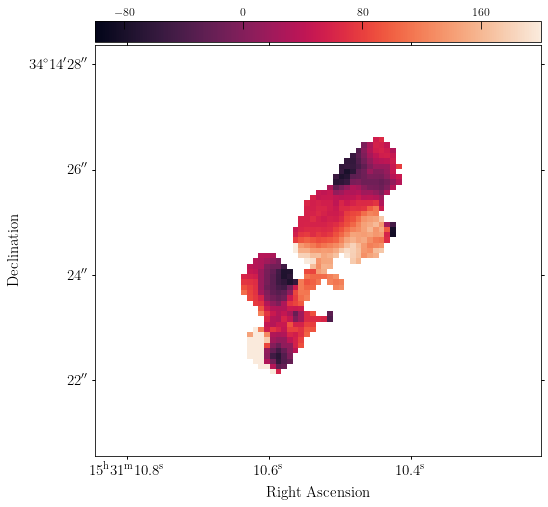

In [ ]:
#draw
fig = plt.figure(figsize=(8,8))
gs1 = GridSpec(1, 1)
gs1.update(wspace=0.01)

hst_zoom = [sf.sdss1531_dict['ra'] + 2e-4, sf.sdss1531_dict['dec']-3e-4, 4 * u.arcsec]

cmap=sns.color_palette("rocket", as_cmap=True)
#ax1
ax1 = fig.add_subplot(gs1[0], projection=m1wcs)

ax1, cb1 = pf.ax_fits_map(hdu=None, data=co_ha_velocity_difference,
                         hdr=moment1_hdr, vmin=-100, vmax=200, 
                         cmap=cmap, coords=hst_zoom, ax=ax1, contour=False)

In [ ]:
co_ha_dispersion_ratio = (ghvd_hdu.data)/(moment2_hdu.data/1e3)
fits.writeto(''.join((new_savepath, 'co_ha_dispersion_ratio.fits')), 
                        co_ha_dispersion_ratio , moment1_hdr, overwrite=True)

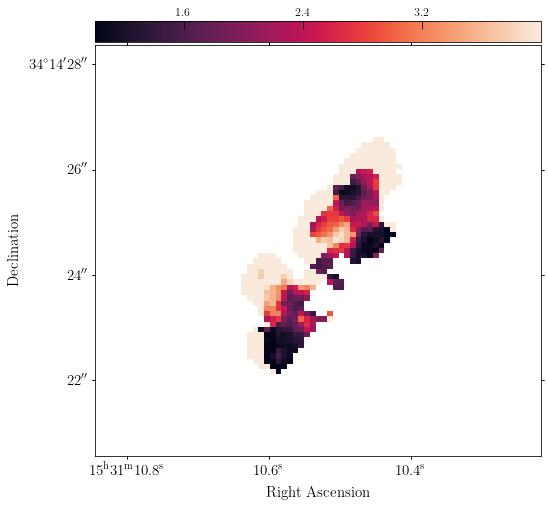

In [ ]:
#draw
fig = plt.figure(figsize=(8,8))
gs1 = GridSpec(1, 1)
gs1.update(wspace=0.01)

hst_zoom = [sf.sdss1531_dict['ra'] + 2e-4, sf.sdss1531_dict['dec']-3e-4, 4 * u.arcsec]

cmap=sns.color_palette("rocket", as_cmap=True)
#ax1
ax1 = fig.add_subplot(gs1[0], projection=m1wcs)

ax1, cb1 = pf.ax_fits_map(hdu=None, data=co_ha_dispersion_ratio,
                         hdr=moment1_hdr, vmin=1, vmax=4, 
                         cmap=cmap, coords=hst_zoom, ax=ax1, contour=False)